# Policy iteration implementation over Jack's car rental example 

Iván Vallés Pérez - 2018

This notebook implements **policy iteration** algorithm from the Sutton & Barto Reinforcement Learning book. It is applied to the Jack's car rental example, also described in the book. In this case, the car returns, though they are implemented in the environment dynamics, they have not been considered for modeling the policy.

In [1]:
import numpy as np
import random
import math
import copy
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class NegativeCarsException(Exception):
    pass


def poisson_pdf(lmb, k):
    return (np.exp(-lmb)*(lmb)**k)/np.math.factorial(k)


class State:
    def __init__(self, st1, st2):
        self.st1 = st1
        self.st2 = st2
    
    def __hash__(self):
        return hash((self.st1.capacity, self.st1.availability, 
                     self.st2.capacity, self.st2.availability))
    
    def __eq__(self, oth):
        return (self.st1.capacity == oth.st1.capacity) and\
               (self.st1.availability == oth.st1.availability) and\
               (self.st2.capacity == oth.st2.capacity) and\
               (self.st2.availability == oth.st2.availability)
    
    def __repr__(self):
        return "State <(C1={0},A1={1},Q1={2})|(C2={3},A2={4},Q2={5})>".format(self.st1.capacity, 
                                                                              self.st1.availability,
                                                                              self.st1.queue,
                                                                              self.st2.capacity,
                                                                              self.st2.availability,
                                                                              self.st2.queue)


def get_possible_states(capacity):
    states = []
    for avl_1 in range(capacity+1):
        for qu_1 in range(capacity-avl_1+1):
            for avl_2 in range(capacity+1):
                for qu_2 in range(capacity-avl_2+1):
                    states.append(State(JacksRentalStation(capacity, avl_1, qu_1, 3, 3), 
                                        JacksRentalStation(capacity, avl_2, qu_2, 4, 2)))
    return states


def get_possible_actions(state, max_transfer=5):
    # State is defined as transfering n from 1 to 2
    st1, st2 = state.st1, state.st2
    return list(range(-min(min(5, st1.capacity-st1.availability), st2.availability), 
                      min(min(5, st2.capacity-st2.availability), st1.availability)+1))


def _update_state(state, cars, clip_max=False):
    state.st1.transfer(cars[0], clip_max)
    state.st2.transfer(cars[1], clip_max)
    return state


def transfer_cars(state, n):
    return _update_state(state, (-n, n))


def rent_cars(state, rentals):
    return _update_state(state, (-rentals[0], -rentals[1]))


def return_cars(state, returns, clip_max=20):
    return _update_state(state, (returns[0], returns[1]), clip_max=True)


def calculate_rent_probabilities(station):
    max_rents = station.availability
    
    probs = [poisson_pdf(station.lambda_rent, k) for k in range(max_rents)]
    probs = probs + [1-sum(probs)]
    return(probs)


def plot_policy(policy, values):
    policy_mat =  np.array(list(policy.values())).reshape([21,21])
    values_mat = np.array(list(values.values())).reshape([21,21])
    # Plot policy
    fig, axes = plt.subplots(1, 2, figsize=[8, 4])
    ax1, ax2 = axes
    im = ax1.imshow(policy_mat, cmap=cm.RdBu_r)
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax1)
    plt.sca(ax1)
    for i in range(21):
        for j in range(21):
            text = plt.text(j, i, policy_mat[i, j],
                           ha="center", va="center", color="w")
    plt.xticks(np.arange(21), range(21), rotation=90)
    plt.yticks(np.arange(21), range(21), rotation=0)
    plt.xlabel("Station 1")
    plt.ylabel("Station 2")
    plt.title("Policy of car distribution")
    # Plot value function
    im = ax2.imshow(values_mat, cmap=cm.hot)
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax2)
    plt.sca(ax2)
    plt.xticks(np.arange(21), range(21), rotation=90)
    plt.yticks(np.arange(21), range(21), rotation=0)
    plt.xlabel("Station 1")
    plt.ylabel("Station 2")
    plt.title("Value function for car distribution")
    fig.tight_layout()
    plt.show()

In [3]:
class JacksRentalStation:
    def __init__(self, capacity, availability, queue, lambda_rent, lambda_return):
        self.capacity = capacity
        self.availability = availability
        self.queue = queue
        self.lambda_rent = lambda_rent
        self.lambda_return = lambda_return
    
    def transfer(self, n, clip_max=False):
        # In transfers are positive
        if (n < 0) and (-n > self.availability):
            raise NegativeCarsException
        self.availability += n
        if clip_max:
            self.availability = self.availability if self.availability<=self.capacity else self.capacity
        
    def __hash__(self):
        return hash((self.capacity, self.availability, self.queue))
    
    def __repr__(self):
        return "[Station: capacity={0} | availability={1} | queue={2}]"\
               .format(self.capacity, self.availability, self.queue) 
        
    def __eq__(self, oth):
        return self.capacity==oth.capacity and \
               self.availability==oth.availability and \
               self.queue==oth.queue


class PolicyIteration:
    def __init__(self):
        self.possible_states = get_possible_states(20)
        self.policy = dict(zip(self.possible_states, np.zeros(len(self.possible_states)).astype(np.int32)))
        self.values = dict(zip(self.possible_states, np.random.uniform(0,1,len(self.possible_states))))
        self.gamma=0.9
        
    def evaluate_policy(self, state):
        action = self.policy[state] # get best action
        value = self.calculate_action_value(state, action)
        self.values[state] = value
    
    def improve_policy(self):
        for state in set(self.possible_states):
            possible_actions = get_possible_actions(state)
            best_idx = np.argmax([self.calculate_action_value(state, a) for a in possible_actions])
            self.policy[state] = possible_actions[best_idx]
        
    def calculate_action_value(self, state, action):
        state = transfer_cars(copy.deepcopy(state), action)
        st1_rent_probabilities = calculate_rent_probabilities(state.st1)
        st2_rent_probabilities = calculate_rent_probabilities(state.st2)
        
        value = 0
        for st1_rent, st1_rent_prob in enumerate(st1_rent_probabilities):
            for st2_rent, st2_rent_prob in enumerate(st2_rent_probabilities):
                p = st1_rent_prob*st2_rent_prob
                r = 10*(st1_rent + st2_rent) - np.abs(action)*2
                
                new_state = rent_cars(copy.deepcopy(state), (st1_rent, st2_rent))
                new_state = return_cars(new_state, (state.st1.queue, state.st2.queue))

                v_s_prime = self.values[new_state]
                
                value += p*(r+self.gamma*v_s_prime)
        return value

In [4]:
pi = PolicyIteration()

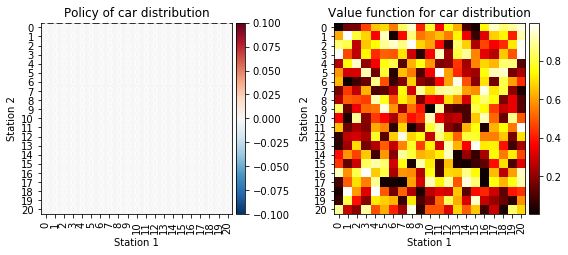

Policy evaluation #1
  Max delta in value function = 186.53600359885655
  Max delta in value function = 167.86744572206456
  Max delta in value function = 111.43616257129585
  Max delta in value function = 88.014308376813
  Max delta in value function = 68.80585957045821
  Max delta in value function = 53.76188979349308
  Max delta in value function = 42.01669759403586
  Max delta in value function = 32.83732280390382
  Max delta in value function = 25.663298898533412
  Max delta in value function = 20.056599771958076
  Max delta in value function = 15.67480481650739
  Max delta in value function = 12.250307031158059
  Max delta in value function = 9.573964340667203
  Max delta in value function = 7.482326195313135
  Max delta in value function = 5.847651328207007
  Max delta in value function = 4.570106296313725
  Max delta in value function = 3.57166841649223
  Max delta in value function = 2.791360736542174
  Max delta in value function = 2.1815280291812087
  Max delta in value func

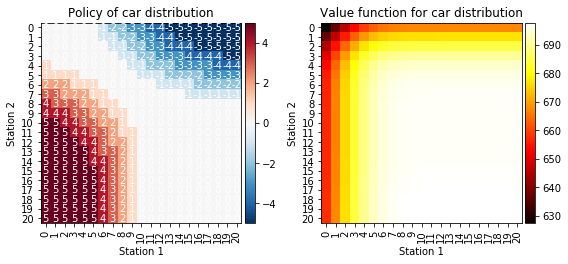

Policy evaluation #2
  Max delta in value function = 26.641027839889034
  Max delta in value function = 0.5615542920209009
Policy improvement #2
  Policy changed 149 cases
-------------------------------------------------


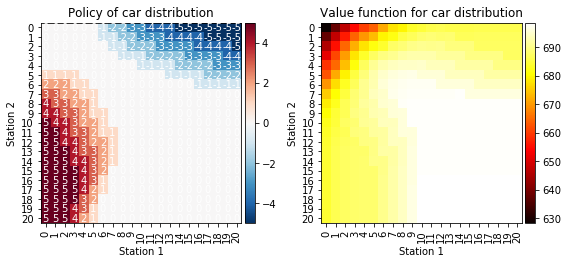

Policy evaluation #3
  Max delta in value function = 6.565981255287511
  Max delta in value function = 0.9259218221739047
Policy improvement #3
  Policy changed 38 cases
-------------------------------------------------


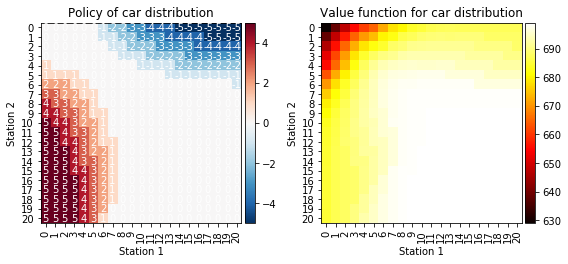

Policy evaluation #4
  Max delta in value function = 4.502251731310821
  Max delta in value function = 0.2137132572858036
Policy improvement #4
  Policy changed 8 cases
-------------------------------------------------


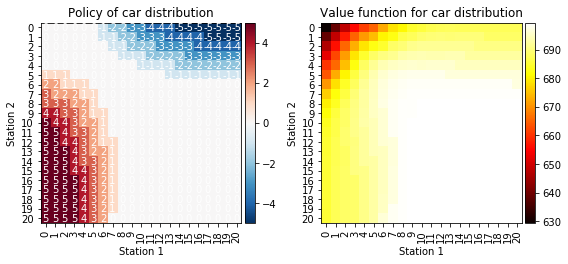

Policy evaluation #5
  Max delta in value function = 4.123121195507792
  Max delta in value function = 0.13020196055094857
Policy improvement #5
  Policy changed 5 cases
-------------------------------------------------


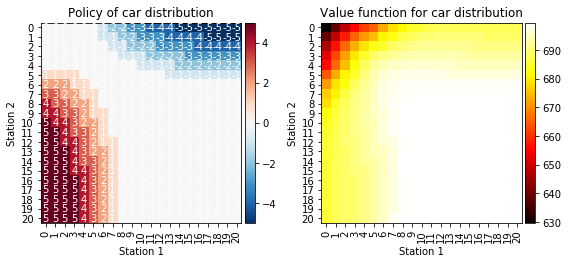

Policy evaluation #6
  Max delta in value function = 1.911342621371091
  Max delta in value function = 0.07945712531807203
Policy improvement #6
  Policy changed 0 cases
-------------------------------------------------
#################################################
Final policy


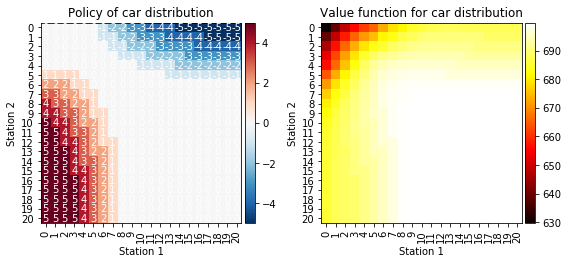

In [5]:
policy_changes = np.Inf
iteration=0
while policy_changes > 2:
    iteration+=1
    plot_policy(pi.policy, pi.values)
    print("Policy evaluation #{0}".format(iteration))
    maxdiff = np.Inf
    while maxdiff > 1:
        values_bk = list(pi.values.values())
        for state in get_possible_states(20):
            pi.evaluate_policy(state)
        maxdiff = np.max(np.abs(np.array(list(pi.values.values()))-np.array(values_bk)))

        print("  Max delta in value function = {0}".format(maxdiff))

    print("Policy improvement #{0}".format(iteration))
    old_policy = list(pi.policy.values())
    pi.improve_policy()
    new_policy = list(pi.policy.values())
    policy_changes = np.sum(np.array(old_policy) != np.array(new_policy))
    print("  Policy changed {0} cases".format(policy_changes))
    print("-------------------------------------------------")
print("#################################################")
print("Final policy")
plot_policy(pi.policy, pi.values)
